In [9]:
import itertools
from collections import defaultdict
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
import matplotlib.pyplot as plt

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
test_path = '/content/drive/My Drive/circuits/c17.test'

In [13]:
# ------------------ Reproducibility ------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------ Data Expansion ------------------
def expand_dont_care(pattern):
    chars = [(c if c in '01' else ['0', '1']) for c in pattern]
    chars = [(c if isinstance(c, list) else [c]) for c in chars]
    return [''.join(bits) for bits in itertools.product(*chars)]

# ------------------ Parse .test File ------------------
def parse_isc_file(filepath):
    combo_to_faults = defaultdict(set)
    fault_to_combos = defaultdict(list)
    current_fault = None

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith("*"):
                continue
            if '/' in line:
                parts = line.split("/")
                fault = parts[0].strip().replace("->", "_") + "/" + parts[1].strip()
                current_fault = fault
            elif ':' in line and current_fault:
                parts = line.split(":")[1].strip().split()
                input_pattern = parts[0]
                output_pattern = parts[1] if len(parts) > 1 else ""
                input_expanded = expand_dont_care(input_pattern)
                output_expanded = expand_dont_care(output_pattern)
                for xi in input_expanded:
                    for yo in output_expanded:
                        combined = xi + yo
                        combo_to_faults[combined].add(current_fault)
                        fault_to_combos[current_fault].append(combined)
    return combo_to_faults, fault_to_combos

# ------------------ Dataset Builder ------------------
def build_multilabel_dataset(combo_to_faults):
    all_faults = sorted({f for faults in combo_to_faults.values() for f in faults})
    fault_index = {fault: idx for idx, fault in enumerate(all_faults)}
    dataset = []
    for combo, faults in combo_to_faults.items():
        label_vector = [0] * len(all_faults)
        for fault in faults:
            label_vector[fault_index[fault]] = 1
        features = [int(bit) for bit in combo]
        dataset.append((features, label_vector))
    return dataset, fault_index

In [14]:
# ------------------ PyTorch Dataset ------------------
class FaultDataset(Dataset):
    def __init__(self, data):
        self.samples = data
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        features, labels = self.samples[idx]
        return (
            torch.tensor(features, dtype=torch.float32).unsqueeze(1),
            torch.tensor(labels, dtype=torch.float32)
        )

In [15]:
# ------------------ Load and Prepare ------------------
combo_to_faults, fault_to_combos = parse_isc_file(test_path)
dataset, fault_index = build_multilabel_dataset(combo_to_faults)

train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=SEED)
train_dataset = FaultDataset(train_data)
val_dataset = FaultDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def get_data_from_loader(loader):
    X, y = [], []
    for inputs, targets in loader:
        X.append(inputs.numpy())
        y.append(targets.numpy())
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

X_train, y_train = get_data_from_loader(train_loader)
X_val, y_val = get_data_from_loader(val_loader)

X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))

In [16]:
# ------------------ ANN Model ------------------
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(name='auc')]
)


In [17]:
# ------------------ Train ------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler],
    verbose=0
)

# ------------------ Predict and Evaluate ------------------
y_pred = (model.predict(X_val) > 0.5).astype(int)
f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

# ------------------ Fault-Type Accuracies ------------------
stuck_at_0_indices = [idx for fault, idx in fault_index.items() if fault.endswith('/0')]
stuck_at_1_indices = [idx for fault, idx in fault_index.items() if fault.endswith('/1')]

def type_accuracy(y_true, y_pred, indices, fault_type):
    y_true_type = y_true[:, indices]
    y_pred_type = y_pred[:, indices]
    correct = (y_true_type == y_pred_type).sum()
    total = y_true_type.size
    acc = correct / total if total > 0 else 0
    print(f"{fault_type} Accuracy: {acc:.4f} ({correct}/{total})")
    return acc

overall_correct = (y_val == y_pred).sum()
overall_total = y_val.size
overall_accuracy = overall_correct / overall_total

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [18]:
# ------------------ Print Final Results ------------------
print(f"\nValidation F1 Score: {f1:.4f}")
print(f"Final Overall Accuracy: {overall_accuracy:.4f} ({overall_correct}/{overall_total})\n")
print("--- Fault-Type Accuracy ---")
type_accuracy(y_val, y_pred, stuck_at_0_indices, "Stuck-at-0")
type_accuracy(y_val, y_pred, stuck_at_1_indices, "Stuck-at-1")


Validation F1 Score: 0.5740
Final Overall Accuracy: 0.9479 (819/864)

--- Fault-Type Accuracy ---
Stuck-at-0 Accuracy: 0.9028 (195/216)
Stuck-at-1 Accuracy: 0.9630 (624/648)


np.float64(0.9629629629629629)

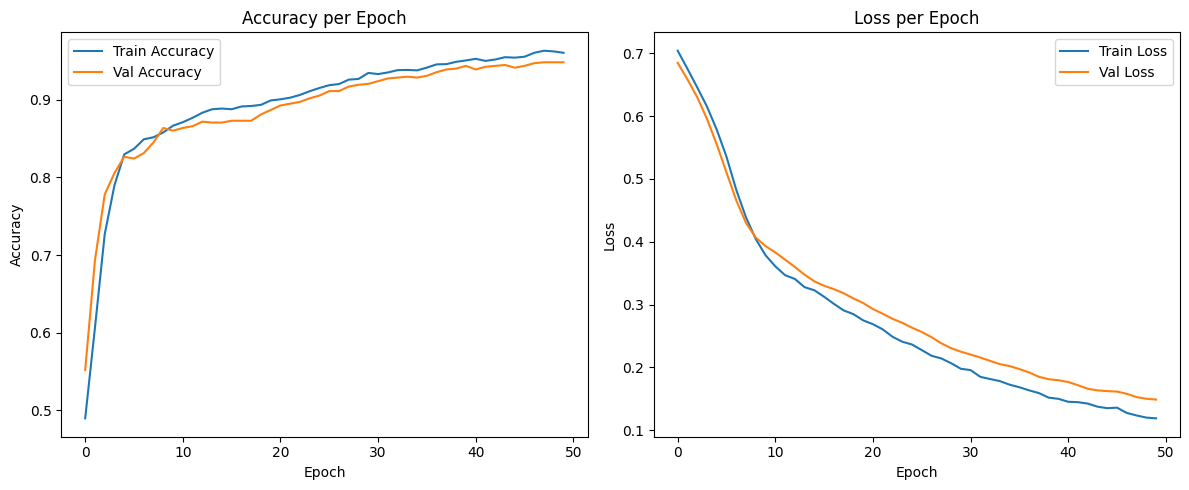

In [19]:
# ------------------ Plot Training Accuracy & Loss ------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.tight_layout()
plt.show()